# A deep feed forward neural network from scratch using numpy

The more I sifted through resources for the duration of this process I found time after time little to no resources that does an absolute full cover of neural networks from scratch, the driving mathematics behind it, and an abstracted perspective on the mechanisms involved. This notebook aims to provide exactly that and leave little to no questions about the complete basics of neural networks and their upscaled cousins, deep neural networks. For a more surface level introduction I already published another [jupyter notebook covering what concepts to understand before reading this notebook](https://github.com/Alt900/AIScratch/blob/main/Introduction%20to%20Artificial%20Intelligence.ipynb) introducing the concepts discussed in this notebook.

## The scope of this project
There will be an intense amount of programming going on in this notebook so in order to make this notebook more readable and digestible here is how the notebook will be proceeding:

    - Data loading, normalization, and separating 
	- Constructing the init dunder method and initializing hyperparameters, activation functions and initialization methods
	- initializing an arbitrary number of layers for our neural network
	- setup the training function calculating z states and applying activation functions
	- Establish a backpropagation routine and parameter updates 
    - Build a prediction function that performs one forward pass with the updated weights and returns the highest probability. 
Throughout each section there will be mathematical explanations and example code that might be able to help understand the processes going on behind this network, it is not necessary to read however I highly recommend it as it provides another angle of understanding to how these networks function and what their limitations are.

### The first steps
This process is performed at the end of the file but will be performed first when the class is imported outside of the main file. Before throwing data towards the network it is a good practice to normalize it and split it into batches, for this network we will only be working with one batch at a time however when a multithreading or GPU acceleration system is implemented later down the line batches will be introduced. For now we are taking a typical batch size of 32 images and feeding it into the network for training and weight adjustments. In the code below we are using the Z-score normalization method notated by $Z=\frac{x-μ}{σ}$ where $μ=\frac{\sum_{i=0}^{n}}{n}$ and $σ=\sqrt{\frac{\sum_{i=0}^{n}(x_i-μ)^2}{n}}$ and. $n$ being the size of the image and $x_i$ being the grayscale value on index $i$. 

In [ ]:
data=np.array(pd.read_csv("train.csv"))
np.random.shuffle(data)
m,n=data.shape
data.T 
Y_train=np.array([int(data[x][:1]) for x in range(round(len(data)*.00076))])
X_train=np.array([data[x][1:]-np.mean([data[x][1:])/np.std([data[x][1:]) for x in range(round(len(data)*.00076))])
Y_test=np.array([int(data[x][:1]) for x in range(round(len(data)*.00078))])[-1]
X_test=np.array([data[x][1:]-np.mean([data[x][1:])/np.std([data[x][1:]) for x in range(round(len(data)*.00078))])[-1]#1 image

In the code above we load the MNIST dataset from a CSV file [available as train.csv in the data sub-folder of this repo](https://github.com/Alt900/AIScratch/tree/main/Data)

### Imports and pre-initialization
Before performing any sort of forward pass operations we need to set up the neural network class with its set of hyperparameters, initialization techniques, activation functions, and network state caches. Since we are using this as a base for the next network, a convolutional neural network, the label vector is processed into a one-hot encoded vector for multi-classification problems such as image classification or object detection. From there we initialize the hyperparameters into the network's variables, define the Softmax, Tanh, ReLU, and Sigmoid activation functions with their corresponding derivative functions, initialization techniques He and Xavier/Xavier Glorot, and techniques to store activated states, z_states, weights, bias, neuron counts, and activation functions.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

class Network():
    def __init__(self,
        input_vector,
        True_Label,
        label_vector,
        alpha,#learning rate for backpropagation
        epochs,
        seed
    ):
        #input processing
        self.input_vector=input_vector
        #one-hot encode the true value labels and the labels
        encoded=np.zeros((len(label_vector),int(max(label_vector))+1))
        encoded[np.arange(len(label_vector)),label_vector]=1
        self.label_vector=encoded
        encoded=np.zeros((len(True_Label),int(max(True_Label))+1))
        encoded[np.arange(len(True_Label)),True_Label]=1
        self.True_Label=encoded

        #hyperparamaters
        self.alpha=alpha
        self.epochs=epochs

        #set a seed for numpy generation to get reproducable results from random weight and bias generation
        np.random.seed(seed)

        self.initialization={
            "Xavier":lambda i,o: np.random.uniform(low=-np.sqrt(6/(i+o)),high=np.sqrt(6/(i+o)),size=(o,i)),
            "He":lambda i,o: np.random.uniform(low=-np.sqrt(6/i),high=np.sqrt(6/i),size=(o,i))
        }

        self.Activations={
            "Tanh": lambda x,derivative :
                1-np.tanh(x)**2 if derivative \
                    else np.tanh(x)
            ,

            "ReLU": lambda zstate,derivative : np.array(
                [0 if x<0 else 1 for x in zstate] if derivative \
                    else [0 if x<0 else x for x in zstate]
            ),

            "Sigmoid": lambda x, derivative : 
                1/1+np.exp(x)*(1-(1/1+np.exp(x))) if derivative \
                else 1/1+np.exp(-x)
        }

        self.preinitdict={
            "function":None,#pointer to a lambda function chosen from the activation functions map
            "neurons":0,#int
            "weights":None,#2D matrix
            "bias":None,#1D vector
            "z_state":None,#1D array
            "activated_state":None#1D array
        }

        self.network={
            "input_layer":self.input_vector,
            "output_layer":dict(self.preinitdict),
            "hidden_layers":{},
            "LossFunction":None
        }
        self.network["output_layer"]["neurons"]=len(label_vector)

    def Softmax(self,vector,derivative=False):
        if derivative:
            n=len(vector)
            SM=self.Softmax(vector,derivative=False)
            JM=np.empty((n,n),dtype=type(SM))
            for i in range(n):
                for j in range(n):
                    if i==j:
                        JM[i,j]=SM[i]*(1-SM[j])
                    else:
                        JM[i,j]=-SM[i]*SM[j]
            return JM
        else:
            stable_exponential=np.exp(vector-np.max(vector))#prevent infinite overflow and underflow
            return stable_exponential/np.sum(stable_exponential)

### Weight/Bias initialization techniques and the activation functions
Weight/Bias initialization techniques are used to ensure a more stable training rather than using random weights or zero weights. Both Xavier/Xavier Glorot and He initialization techniques are based on normal distributions (although Xavier can be based on normal or uniform distribution) however their differences lie in what activation functions are used for each layer in the network. Xavier accepts all activation functions but He initialization is specifically built for the ReLU/Leaky ReLU function in order to prevent the vanishing gradient problem by scaling the weights to a factor of 2/n (n being the number of neurons in the layer). This prevents the dying ReLU neuron problem where neurons get stuck in a state of always outputting zero due to negative weight initialization that could potentially arise from Xavier initialization. The network initialization function created later on already automatically determines what initialization method to use on a layer-to-layer basis so you do not have to worry about adding ReLU anywhere in the network. 

### The math of weight/bias initialization
As stated previously under Xavier/Xavier Glort initialization there can be two types of distributions used, the uniform or normal distribution ranging from [-x,x]. For uniform distribution the formula is $x=\sqrt{\frac{6}{i+o}}$ Where $i$ and $o$ are the lengths of the input and output neurons or the corresponding connecting weights from the previous layer to the current layer. And for normal distribution $x=\sqrt{\frac{2}{i+o}}$. In the examples provided above I used uniform distribution rather than normal but if you want to experiment simply take the line:

In [ ]:
"Xavier":lambda i,o: np.random.uniform(low=-np.sqrt(6/(i+o)),high=np.sqrt(6/(i+o)),size=(o,i)),

And change it to:

In [ ]:
"Xavier":lambda i,o: np.random.normal(low=-np.sqrt(2/(i+o)),high=np.sqrt(2/(i+o)),size=(o,i)),

### Initializing each layer 
Since this is a deep neural network with an arbitrary number of layers, neurons, input size, and output label size we need to initialize each layer dynamically and iteratively for each layer specified in the layercount variable passed in the layer initialization function. Another parameter we pass would be the neuron distribution list or simply a number of neurons. If a list of equal size to the number of layers is passed then the function would simply accept the list, otherwise a list of neuron distributions is generated starting in reversed order with the number of neurons specified, then performing floor division (to ensure the resulting operating is a int) with the denominator being the layer number. I'E: 200 neurons over 2 layers = H1(100), H2(200). The weight initializations are also based on these lists as well. Similarly a list of activation functions can be passed instead of a single string or universal activation function, allowing for more modularity and low-level control/tuning of the network, So for a 3 layer network you could setup Tanh in H1, Sigmoid in H2, and ReLU in H3.


As previously mentioned when mapping out lambda functions in a dict for weight/bias initialization techniques, the layer initialization will also contain conditionals checking exactly what type of function is being used in the neural network. This ensures an extra layer of stability in the network since if we are using ReLU or LeakyReLU we want to initialize the weights/bias based on the He initialization function rather than Xavier initialization and risk negative weights causing the dying ReLU neuron problem.

In [ ]:
def initialize_layers(self,neurondist,layercount,activation):
    self.layercount=layercount+1
    if type(neurondist)==int:
        neurondist=[neurondist//y for y in reversed([x for x in range(1,self.layercount)])]
    if type(activation)==str:
        if activation=="Softmax":
            print("Cannot add softmax activation for hidden layer activation functions.")
            exit()
        if type(activation)==list and len(activation)!=self.layercount:
            print("The list of activation functions are not complete")
            exit()
        else:
            activation=[activation for y in range(1,self.layercount)]
            
    for x in range(1,self.layercount):
        self.network["hidden_layers"][x]=dict(self.preinitdict)
        self.network["hidden_layers"][x]["neurons"]=neurondist[x-1]
        args=[[neurondist[x-1],len(self.input_vector[0])] if x==1 else [neurondist[x-1],neurondist[x-2]]]
        self.network["hidden_layers"][x]["function"]=self.Activations[activation[x-1]]
        if activation[x-1]=="ReLU":
            self.network["hidden_layers"][x]["weights"]=self.initialization["He"](args[0][1],args[0][0])
            self.network["hidden_layers"][x]["bias"]=self.initialization["He"](1,args[0][0])
        else:
            self.network["hidden_layers"][x]["weights"]=self.initialization["Xavier"](args[0][1],args[0][0])
            self.network["hidden_layers"][x]["bias"]=self.initialization["Xavier"](1,args[0][0])
    self.network["output_layer"]["weights"]=self.initialization["Xavier"](args[0][0],len(self.label_vector))
    self.network["output_layer"]["bias"]=self.initialization["Xavier"](1,len(self.label_vector))

### Z state calculations, applications of activation functions, and the forward pass process
Now it's finally time to get into the driving forces for sequential models from ChatGPT, Google Gemini, and Microsoft Copilot to Google translate, Siri, and Apple Vision Pro with augmented reality. Starting at the first computation performed, the z state, consisting of the dot product of the previous layers output and the weights with a bias term added, mathematically the equation is as follows:
$$\sum_{i=0}^{OutputLength} (O_1*W_1+O_2*W_2 ... O_N*W_N)+Bias$$ Since the activation function is completely up to you the exact calculations will vary with each activation function, however since I only included three activation functions for now here is how each calculation should look with their corresponding derivative which we will use later on in the network.

Sigmoid:
$$σ = \frac{1}{1+e^{-x}}$$ $$σ'=σ*(1-σ)$$ Tanh: $$Tanh=\frac{{e^x}-{e^{-x}}}{{e^{-x}}+{e^x}}$$ $$Tanh'=1-(\frac{{e^x}-{e^{-x}}}{{e^{-x}}+{e^x}})^2$$
ReLU: $$ReLU=max(0,x)$$ $$ReLU'=\begin{cases}0&if x < 0 \\1&if x > 0\end{cases}$$ There are also a few other activation functions with different use cases you could attempt to implement if messing around with the code is more your style, for example the swish activation function (also known as the scaled exponential linear unit with a shift, you will see why below) developed by Google in 2017: $$Swish = (x*σ) *(β*x)$$ $β$ in this instance is a hyperparameter itself acting as a function shape control factor, effectively dictating how the function will [squash function outputs](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html) allowing for a greater control over what data features are abstracted in the network.


From here onwards the process is pretty automatic, each z state calculation is applied to each neuron in a layer, its output taken and fed into an activation function for each neuron, producing an output the size of the layers neurons. Then each output of that layer is fed into the z state calculation of the next layer as x, and so on so forth. This process is always automated on larger systems and that automated system is what I provided below, however if you're struggling to understand exactly how this process is structured I would highly recommend messing with the fundamentals on a smaller scale.

Credit to [WarshipConn](https://github.com/WarshipConn?tab=overview&from=2024-03-01&to=2024-03-31) for conjuring up some smaller scale code that operates with single and multiple neurons on a single layer 

In [ ]:
#for a singl neuron
x=np.array((1,2,3))#the output of the previous layer or input layer data
w=np.array((4,5,6))#a single weight values list 
b=7#the bias term

def f(x):
    return 1/(1=np.exp(-x))#sigmoid activation function

def neuron(x, w, b, f):
    if len(x) == len(w):
        return f(sum(x*w) + b)
    else:
        return "Missing weights or bias"

###for multiple neurons###
x = np.array((1, 2))
w = np.array(((1,2), (3,4), (5,6))) #3 neurons, 2 input & weight pairs each
b = np.array((1, 2, 3))

def neurons(x, w, b, f):
    if w.shape[0] == len(b):
        if w.shape[1] == len(x):

            xw = np.array([sum(i) for i in x*w])
            result = [0] * w.shape[0]
            
            for i in range(w.shape[0]):
                result[i] = f(xw[i] + b[i])

            return result
        else:
            return "Mismatch between inputs and weights"
    else:
        return "Missing weights or bias for some neurons"
print(neurons(x, w, b, f))

### The automated code

In [ ]:
def Train(self):
    for _ in range(0,self.epochs):
        for i in range(len(self.input_vector)):
            for x in range(1,self.layercount):
                z=np.empty(shape=self.network["hidden_layers"][x]["neurons"])
                for y in range(self.network["hidden_layers"][x]["neurons"]):
                    if x==1:
                        z.flat[y]=np.sum(np.dot(
                            self.network["hidden_layers"][x]["weights"][y],
                            self.input_vector[i]
                        )+self.network["hidden_layers"][x]["bias"][y])
                    else:
                        z.flat[y]=np.sum(np.dot(
                            self.network["hidden_layers"][x]["weights"][y],
                            self.network["hidden_layers"][x-1]["activated_state"]
                        )+self.network["hidden_layers"][x]["bias"][y])
                self.network["hidden_layers"][x]["z_state"]=z
                self.network["hidden_layers"][x]["activated_state"]=self.network["hidden_layers"][x]["function"](z,False)

            z=np.empty(shape=self.network["output_layer"]["neurons"])
            for y in range(self.network["output_layer"]["neurons"]):
                z.flat[y]=np.sum(np.multiply(
                    self.network["output_layer"]["weights"][y],
                    self.network["hidden_layers"][x]["activated_state"]
                )+self.network["output_layer"]["bias"][y])
            self.network["output_layer"]["z_state"]=z
            self.network["output_layer"]["activated_state"]=self.Softmax(z)
            self.backpropagation(i)

        Loss=-np.sum(self.True_Label[i] * np.log(self.network["output_layer"]["activated_state"]))
        plt.plot(_,Loss,'go')
        print(f'Loss: {Loss} on epoch {_}')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Gradient descent direction")
    plt.show()

### Calculating loss
In order to understand how accurate or inaccurate our network is we need a loss function to generate that metric. The choice of loss is categorical cross-entropy loss, again since this is a multi-classification network we will be dealing with softmax, and CCE is one of the few options we have aside from its variants sparse CCE and logit CCE. CCE's equation is as follows and only consists of three operations we need to perform:
$$CCE=-\sum_{i}^{C}=t_i*log(f(Z)_i)$$

In [ ]:
Loss=-np.sum(self.True_Label[i] * np.log(self.network["output_layer"]["activated_state"]))

There are plenty of other loss functions to look at such as mean squared error/MSE, Hinge loss, Huber loss, smooth mean absolute error/SMAE, ect but CCE and its variants are typically the only loss functions used in multi-classification problems as it deals with probabilities structured around the softmax activation function. 

### Backpropagation, the steepest learning curve in AI for beginners
Compared to how the first half of this network has been constructed it seems pretty straight forward, just compute the z state and apply the activation function, backpropagation should be the same but in reverse right? In essence it is but there are a lot of mathematical complexities behind the algorithm and for good reason, backpropagation is the mechanism behind how artificial intelligence actually can learn. It involves gradients, how gradient descent works and the relevant multivariable calculus, derivatives, the chain rule of calculus, linear algebra, and a mix of matrix and vector operations. If you already have some idea of how calculus works such as the chain rule and how to find derivatives of functions might see why this starts to become a problem. In the forward pass operations we calculate the Z state first, taking inputs X, W, and B then producing a single output, that output is then fed into an activation function, which then serves as the input for the next Z state and so on. This introduces a (technically 2) new element(s) for beginners in Calculus, multivariable composite functions. In the case of neural networks it's multivariable composite function looks like $f(z(({\sum_{i=0}^i} X_i*W_i)+B_i))$ meaning our derivative will start like $f'(z'(({\sum_{i=0}^i} X_i*W_i)+B_i))$ This complicates the chain rule but can be generally addressed with the chain rule as $\frac{∂E^L}{∂A^L}*\frac{∂A^L}{∂Z^L}*\frac{∂Z^L}{∂W^L}$. That only solves one problem however, this only applies to one layer of the network or the output layer, in order to perform backpropagation properly we have to send this resulting change in the error function with respect to the weights back through the rest of the layers. If we had say a network with 10 hidden layers and an output layer and we wanted to find the effect the weights in layer 8 has on the loss function and subsequently the proceeding layers. The chain rule would then be extended further to this:
$$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂W^8}$$ and if you are curious to see from the output layer to the first hidden layer: $$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂A^2}*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂A^1}*\frac{∂A^1}{∂Z^1}*\frac{∂Z^1}{∂W^1}$$ This [multivariable multicomposite function chain rule](https://math.libretexts.org/Bookshelves/Calculus/Calculus_(OpenStax)/14%3A_Differentiation_of_Functions_of_Several_Variables/14.05%3A_The_Chain_Rule_for_Multivariable_Functions) is a mind melter to get around sometimes especially when beginning with AI and/or ML. But getting into the depths of the equation and what each component is it takes a huge load off someones mind trying to just take the equations head on, the relevant calculus is a handfull to explain and would make this notebook extremely long so I highly reccomend checking out [3B1B's series on calculus](https://www.youtube.com/watch?v=WUvTyaaNkzM&list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr), he does an amazing job of making complex topics like calculus easy to digest.


Now how do we even begin trying to implement this into a neural network? Well as previously mentioned once it's boiled down it's easier to understand, we want to find how much the Loss function changes with respect to a targeted parameter, bias or weights, and update our weights based on the change that causes the greatest decrease in the loss function's output. This is the idea we need to implement for each weight, but we don't have to re-calculate partial derivatives for each layer we go through, a more computationally friendly approach would be to calculate the gradients for the current layer and store it to be used as a input to the next stage of computation in the chain rule for the next layer. We can achieve this by instantizing the first weight gradient in the output layer, taking the result of $\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂W^{11}}$ and multiplying the next partial derivative $\frac{∂A^{10}}{∂Z^{10}}$ note that : $\frac{∂Z^{11}}{∂W^{11}}\rightarrow\frac{∂Z^{11}}{∂A^{10}}$. Proceeding with similar calculation steps used in the output layer we can replace the instantized gradient of $\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂W^{11}}$ with $\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂W^10}$. Repeating this process for each layer and applying the relevant gradient calculations to the parameters of that layer we effectively performed the entire chain rule by the time we finish the backpropagation process. This process mathematically for each layer and each parameter would look like the following without caching the gradient:

Again noting: $\frac{∂Z^L}{∂W^L} \rightarrow \frac{∂Z^L}{∂A^{L-1}}$
#### Without Cache
$DW^{11}$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂W^{11}}$

$DB^{11}$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂B^{11}}$

$DW^{10}$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂W^{10}}$

$DB^{10}$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂B^{10}}$

$DW^9$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂W^9}$

$DB^9$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂B^9}$

$DW^8$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂W^8}$

$DB^8$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂B^8}$

$DW^7$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂W^7}$

$DB^7$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂B^7}$

$DW^6$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂W^6}$

$DB^6$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂B^6}$

$DW^5$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂W^5}$

$DB^5$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂B^5}$

$DW^4$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂W^4}$

$DB^4$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂B^4}$

$DW^3$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂W^3}$

$DB^3$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂B^3}$

$DW^2$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂A^2}*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂W^2}$

$DB^2$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂A^2}*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂B^2}$

$DW^1$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂A^2}*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂A^1}*\frac{∂A^1}{∂Z^1}*\frac{∂Z^1}{∂W^1}$

$DB^1$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂A^{10}}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂A^9}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂A^8}*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂A^7}*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂A^6}*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂A^5}*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂A^4}*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂A^3}*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂A^2}*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂A^1}*\frac{∂A^1}{∂Z^1}*\frac{∂Z^1}{∂B^1}$


#### With Cache

$DW^{11}$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂W^{11}}$

$DB^{11}$=
$\frac{∂E^{11}}{∂A^{11}}*\frac{∂A^{11}}{∂Z^{11}}*\frac{∂Z^{11}}{∂B^{11}}$

$DW^{10}$=
$DW^{11}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂W^{10}}$

$DB^{10}$=
$DB^{11}*\frac{∂A^{10}}{∂Z^{10}}*\frac{∂Z^{10}}{∂B^{10}}$

$DW^9$=
$DW{10}^*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂W^9}$

$DB^9$=
$DB^{10}*\frac{∂A^9}{∂Z^9}*\frac{∂Z^9}{∂B^9}$

$DW^8$=
$DW^9*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂W^8}$

$DB^8$=
$DB^9*\frac{∂A^8}{∂Z^8}*\frac{∂Z^8}{∂B^8}$

$DW^7$=
$DW^8*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂W^7}$

$DB^7$=
$DB^8*\frac{∂A^7}{∂Z^7}*\frac{∂Z^7}{∂B^7}$

$DW^6$=
$DW^7*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂W^6}$

$DB^6$=
$DB^7*\frac{∂A^6}{∂Z^6}*\frac{∂Z^6}{∂B^6}$

$DW^5$=
$DW^6*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂W^5}$

$DB^5$=
$DB^6*\frac{∂A^5}{∂Z^5}*\frac{∂Z^5}{∂B^5}$

$DW^4$=
$DW^5*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂W^4}$

$DB^4$=
$DB^5*\frac{∂A^4}{∂Z^4}*\frac{∂Z^4}{∂B^4}$

$DW^3$=
$DW^4*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂W^3}$

$DB^3$=
$DB^4*\frac{∂A^3}{∂Z^3}*\frac{∂Z^3}{∂B^3}$

$DW^2$=
$DW^3*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂W^2}$

$DB^2$=
$DB^3*\frac{∂A^2}{∂Z^2}*\frac{∂Z^2}{∂B^2}$

$DW^1$=
$DW^2*\frac{∂A^1}{∂Z^1}*\frac{∂Z^1}{∂W^1}$

$DB^1$=
$DB^2*\frac{∂A^1}{∂Z^1}*\frac{∂Z^1}{∂B^1}$

Just comparing the two makes it generally obvious why caching is a very important process, the code below is the cache version. I would provide the full version but that's an extremely restrictive and rigorous process, as well as the code itself would be very large and impractical to implement given arbitrary layer sizes. With that being said here is the vanilla backpropagation algorithm with a cache: 

In [ ]:
def backpropagation(self,i):
    DL=self.network["output_layer"]["activated_state"]-self.True_Label[i]
    for x in reversed(range(1,len(self.network["hidden_layers"])+1)):
        if x==len(self.network["hidden_layers"]):
            DW=np.dot(
                np.multiply(
                    self.network["output_layer"]["weights"].T,
                    DL
                ),
                self.Softmax(self.network["output_layer"]["z_state"],True)
            )

            DB=np.sum(DW.T,axis=1,keepdims=True)

            self.network["output_layer"]["weights"]=(self.network["output_layer"]["weights"].T-self.alpha*DW).T
            self.network["output_layer"]["bias"]=self.network["output_layer"]["bias"]-self.alpha*DB

            DA=np.multiply(
                self.network["output_layer"]["weights"].T.dot(DW.T),
                self.network["hidden_layers"][x]["function"](
                    self.network["hidden_layers"][x]["z_state"],True
                )
            )
            DW=DA.T.dot(self.network["hidden_layers"][x]["activated_state"])
            DB=DW

            self.network["hidden_layers"][x]["weights"]=(self.network["hidden_layers"][x]["weights"].T-self.alpha*DW).T
            self.network["hidden_layers"][x]["bias"]=(self.network["hidden_layers"][x]["bias"].T-self.alpha*DB).reshape(len(DB),1)

        elif x!=len(self.network["hidden_layers"]) and x!=1:
            DW=np.multiply(
                self.network["hidden_layers"][x+1]["weights"].T.dot(DW),
                self.network["hidden_layers"][x]["function"](
                    self.network["hidden_layers"][x]["z_state"],True
                )
            )
            DW=DW*(self.network["hidden_layers"][x]["activated_state"])
            DB=DW
            self.network["hidden_layers"][x]["weights"]=(self.network["hidden_layers"][x]["weights"].T-self.alpha*DW).T
            self.network["hidden_layers"][x]["bias"]=(self.network["hidden_layers"][x]["bias"].T-self.alpha*DB).reshape(len(DB),1)

        else:
            pass

There are two new things to point out here, one the weights are transposed and two nested multiplications within dot product of the output layer's weight gradient. The purpose of transposing is to make multiplication compatible between the weight gradient matrix and the weight matrix itself, since backpropagation operates in reverse order to that of forward propagation the weights are used in a mirrored manor. Where H1-H2 weights might be shape (20,30) during forward propagation, during backpropagation we are moving from H2-H1 so the weights appear as (30,20). During parameter updates, we would transpose the weights again subtracting the gradient multiplied by the learning rate, then re-transposing the weights to account for dimensions. Thus ensuring we can use the updated weights and bias the same exact way during the forward pass but under a new iteration/epoch.

### Derivatives and the Softmax Jacobian matrix
If you already have a step in the door to calculus then derivatives are pretty familiar, but what happens when we get a function that takes a vector as an input and produces a probability vector output? Well we get a matrix of partial derivatives or the Jacobian matrix....which introduces us to a new field of calculus, vector calculus, yayyyy. The only takeaway we need from vector calculus is how we obtain the gradient of a vector-valued function such as softmax accepting an arbitrary number of variables in a given vector and returning one of equal size. Because of this property, equal sizes, we can easily approximate the gradient through a matrix of partial derivatives of the softmax's output index with the index of the output. However since there are $NxN$ possible changes with respects to a given input/output pair we get a matrix of size $NxN$ which will look like the following:
$$
\newcommand\ColV[1]{\begin{bmatrix}#1\end{bmatrix}}
J=[\frac{∂f}{∂x_1}\dots \frac{∂f}{∂x_n}]=\ColV{∇^Tf_1\\ \vdots\\∇^Tf_n}=\begin{bmatrix}
	\frac{∂f_1}{∂x_1} & \dots & \frac{∂f_1}{∂x_n}\\
	\dots & \ddots & \dots \\
	\frac{∂f_n}{∂x_1} & \dots & \frac{∂f_n}{∂x_n}
  \end{bmatrix}
$$
For as scary as this looks its not that hard to implement and is under the Softmax function defined earlier as

In [ ]:
n=len(vector)
SM=self.Softmax(vector,derivative=False)
JM=np.empty((n,n),dtype=type(SM))#initialize the NxN matrix
for i in range(n):
    for j in range(n):
        if i==j:
            JM[i,j]=SM[i]*(1-SM[j])#the special case where ∂f_n and ∂x_n subscript n are the same index
        else:
            JM[i,j]=-SM[i]*SM[j]

This would impact the shape of the first gradient when performing backpropagation on the first output layer but since the dot product is performed the original weight shape is maintained even when this would have a arbitrary shape of $NxN$ because $N$ classes are what dictate the output layer weight shapes, the bias shapes, and the softmax input/output shapes.

Congratulations if you made it this far and your brain feels like this, the only thing left from here is exploring some problems with this backpropagation method, putting all the code together, and final remarks. (Or extra activation functions if you choose to read that section)


![](https://media1.tenor.com/m/V40hZioO7S8AAAAd/spin-kermit-the-frog.gif)

### The problems facing vanilla backpropagation and optimizers addressing these problems FINISH RMSPROP
This design especially has multiple problems, notably [Exploding Gradients](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf), [Vanishing Gradients](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf), and [Saddle Points](https://arxiv.org/abs/2111.14069), [Local Minima](http://www.gatsby.ucl.ac.uk/~porbanz/teaching/UN3106S18/slides_08Feb.pdf)(even though most optimization algorithms can suffer from this problem). There are much different optimization techniques for various problems and even activation functions to address something like [vanishing gradients in ReLU solved with Swish](https://www.educative.io/answers/what-is-the-swish-activation-function), however activation function tuning can only go so far, we need a different type of optimization algorithm to efficiently and dynamically update the learning rate in order to converge faster to a local/global minima. A popular choice on the front end design of AI is the Adam optimizer, even [Tensorflow displayed Adam as an example optimizer on its website](https://www.tensorflow.org/) and for good reason. Adam or ADAptive Moment estimation, seems to merge STG and RMSProp (Stochastic Gradient Descent and Root Mean Squared Propagation) with a momentum factor added to the algorithm. I will be going further in depth about Adam in the coming notebooks but for now a good median would be RMSProp. RMSprop offers a pretty fast training rate and faster divergence toward a local/global minima, it takes the decaying average of the squares of previously calculated gradients then divides the learning rate by the resulting calculation, changing the learning rate dynamically. The formula for the updated parameter is as follows:
$$E[g^2]_t=βE[g^2]_{t-1}+(1-β)\frac{ẟC}{ẟW}^2$$

Another pretty intimidating piece of math but again like vanilla backpropagation, its implementation is pretty straightforward as it only updates the learning rate with the following, note this is just pseudocode and is not a functional piece of code especially for this network. 

In [ ]:
#epsilon, rho, alpha, theta 
ε = 1e-12
β = .9
α = self.alpha
#if L=O
#RM=0
#if L!=O
RM=β*RM+(1-β)*(DW**2)
#Parameter Theta
RMS_Theta = Theta - α * DW / np.sqrt(RM+ε)

### Putting it a together

Loss: 79.43918414645225 on epoch 0
Loss: 79.43793883212028 on epoch 1
Loss: 79.43669044499698 on epoch 2
Loss: 79.43543896990833 on epoch 3
Loss: 79.43418439156773 on epoch 4
Loss: 79.43292669457485 on epoch 5
Loss: 79.43166586341448 on epoch 6
Loss: 79.43040188245575 on epoch 7
Loss: 79.42913473595041 on epoch 8
Loss: 79.42786440803226 on epoch 9
Loss: 79.42659088271543 on epoch 10
Loss: 79.42531414389346 on epoch 11
Loss: 79.42403417533818 on epoch 12
Loss: 79.42275096069804 on epoch 13
Loss: 79.42146448349743 on epoch 14
Loss: 79.42017472713508 on epoch 15
Loss: 79.41888167488284 on epoch 16
Loss: 79.41758530988415 on epoch 17
Loss: 79.41628561515346 on epoch 18
Loss: 79.41498257357395 on epoch 19
Loss: 79.41367616789694 on epoch 20
Loss: 79.41236638074014 on epoch 21
Loss: 79.41105319458619 on epoch 22
Loss: 79.40973659178178 on epoch 23
Loss: 79.40841655453553 on epoch 24
Loss: 79.40709306491732 on epoch 25
Loss: 79.40576610485608 on epoch 26
Loss: 79.4044356561387 on epoch 27
Los

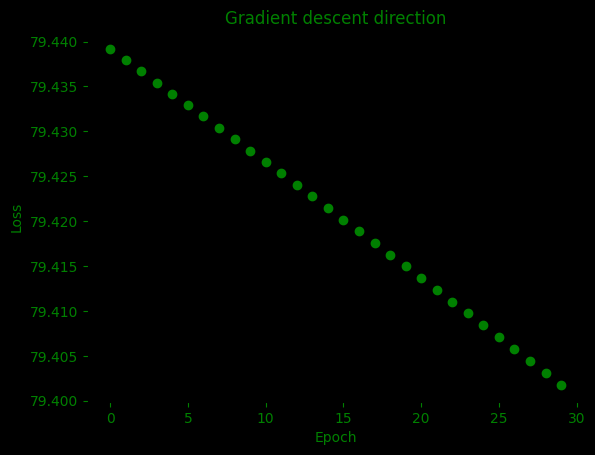

internal hyperparameter shapes for hidden layer 1:
weights: (20, 784)
bias: (20, 1)
internal hyperparameter shapes for hidden layer 2:
weights: (25, 20)
bias: (25, 1)
internal hyperparameter shapes for hidden layer 3:
weights: (33, 25)
bias: (33, 1)
internal hyperparameter shapes for hidden layer 4:
weights: (50, 33)
bias: (50, 1)
internal hyperparameter shapes for hidden layer 5:
weights: (100, 50)
bias: (100, 1)
[3.17861516e-57 1.06944498e-60 1.34862970e-35 7.26199292e-28
 9.99345880e-01 4.28847614e-51 4.77270230e-60 2.41117818e-41
 7.82796613e-46 6.54119762e-04]
Network prediction 4
Real label: 0


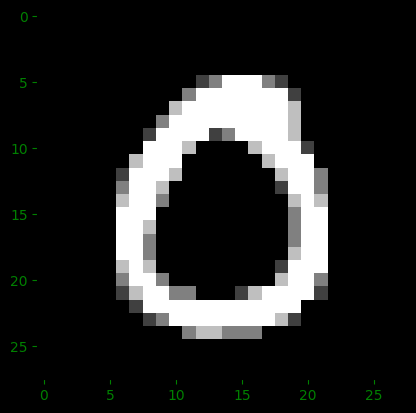

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#for fancy matplotlib effects
plt.rcParams['grid.color']="green"
plt.rcParams['axes.facecolor']="black"
plt.rcParams['figure.facecolor']="black"
plt.rcParams['text.color']="green"
plt.rcParams['axes.labelcolor']="green"
plt.rcParams['xtick.color']="green"
plt.rcParams['ytick.color']="green"


class Network():
    def __init__(self,
        input_vector,
        True_Label,
        label_vector,
        alpha,#learning rate for backpropagation
        epochs,
        seed
    ):
        #input processing
        self.input_vector=input_vector
        #one-hot encode the true value labels and the labels
        encoded=np.zeros((len(label_vector),int(max(label_vector))+1))
        encoded[np.arange(len(label_vector)),label_vector]=1
        self.label_vector=encoded
        encoded=np.zeros((len(True_Label),int(max(True_Label))+1))
        encoded[np.arange(len(True_Label)),True_Label]=1
        self.True_Label=encoded

        #hyperparamaters
        self.alpha=alpha
        self.epochs=epochs

        #set a seed for numpy generation to get reproducable results from random weight and bias generation
        np.random.seed(seed)

        self.initialization={
            "Xavier":lambda i,o: np.random.uniform(low=-np.sqrt(6/(i+o)),high=np.sqrt(6/(i+o)),size=(o,i)),
            "He":lambda i,o: np.random.uniform(low=-np.sqrt(6/i),high=np.sqrt(6/i),size=(o,i))
        }

        self.Activations={
            "Tanh": lambda x,derivative :
                1-np.tanh(x)**2 if derivative \
                    else np.tanh(x)
            ,

            "ReLU": lambda zstate,derivative : np.array(
                [0 if x<0 else 1 for x in zstate] if derivative \
                    else [0 if x<0 else x for x in zstate]
            ),

            "Sigmoid": lambda x, derivative : 
                1/1+np.exp(x)*(1-(1/1+np.exp(x))) if derivative \
                else 1/1+np.exp(-x)
        }

        self.preinitdict={
            "function":None,#pointer to a lambda function chosen from the activation functions map
            "neurons":0,#int
            "weights":None,#2D matrix
            "bias":None,#1D vector
            "z_state":None,#1D array
            "activated_state":None#1D array
        }

        self.network={
            "input_layer":self.input_vector,
            "output_layer":dict(self.preinitdict),
            "hidden_layers":{},
            "LossFunction":None
        }
        self.network["output_layer"]["neurons"]=len(label_vector)




    def generate_report(self):
        r=[]
        for x in OBJ.network["hidden_layers"]:
            r.append(f"internal hyperparameter shapes for hidden layer {x}:\nweights: {self.network['hidden_layers'][x]['weights'].shape}\nbias: {self.network['hidden_layers'][x]['bias'].shape}")
        return r

    def Softmax(self,vector,derivative=False):
        if derivative:
            n=len(vector)
            SM=self.Softmax(vector,derivative=False)
            JM=np.empty((n,n),dtype=type(SM))
            for i in range(n):
                for j in range(n):
                    if i==j:
                        JM[i,j]=SM[i]*(1-SM[j])
                    else:
                        JM[i,j]=-SM[i]*SM[j]
            return JM
        else:
            stable_exponential=np.exp(vector-np.max(vector))#prevent infinite overflow and underflow
            return stable_exponential/np.sum(stable_exponential)
        
    def backpropagation(self,i):
        DL=self.network["output_layer"]["activated_state"]-self.True_Label[i]
        for x in reversed(range(1,len(self.network["hidden_layers"])+1)):
            if x==len(self.network["hidden_layers"]):
                DW=np.dot(
                    np.multiply(
                        self.network["output_layer"]["weights"].T,
                        DL
                    ),
                    self.Softmax(self.network["output_layer"]["z_state"],True)
                )

                DB=np.sum(DW.T,axis=1,keepdims=True)

                self.network["output_layer"]["weights"]=(self.network["output_layer"]["weights"].T-self.alpha*DW).T
                self.network["output_layer"]["bias"]=self.network["output_layer"]["bias"]-self.alpha*DB

                DA=np.multiply(
                    self.network["output_layer"]["weights"].T.dot(DW.T),
                    self.network["hidden_layers"][x]["function"](
                        self.network["hidden_layers"][x]["z_state"],True
                    )
                )
                DW=DA.T.dot(self.network["hidden_layers"][x]["activated_state"])
                DB=DW

                self.network["hidden_layers"][x]["weights"]=(self.network["hidden_layers"][x]["weights"].T-self.alpha*DW).T
                self.network["hidden_layers"][x]["bias"]=(self.network["hidden_layers"][x]["bias"].T-self.alpha*DB).reshape(len(DB),1)

            elif x!=len(self.network["hidden_layers"]) and x!=1:
                DW=np.multiply(
                    self.network["hidden_layers"][x+1]["weights"].T.dot(DW),
                    self.network["hidden_layers"][x]["function"](
                        self.network["hidden_layers"][x]["z_state"],True
                    )
                )
                DW=DW*(self.network["hidden_layers"][x]["activated_state"])
                DB=DW
                self.network["hidden_layers"][x]["weights"]=(self.network["hidden_layers"][x]["weights"].T-self.alpha*DW).T
                self.network["hidden_layers"][x]["bias"]=(self.network["hidden_layers"][x]["bias"].T-self.alpha*DB).reshape(len(DB),1)

            else:
                pass

    def get_prediction(self,image):
        for x in range(1,self.layercount):
            z=np.empty(shape=self.network["hidden_layers"][x]["neurons"])
            for y in range(self.network["hidden_layers"][x]["neurons"]):
                if x==1:
                    z.flat[y]=np.sum(np.dot(
                        self.network["hidden_layers"][x]["weights"][y],
                        image
                    )+self.network["hidden_layers"][x]["bias"][y])
                else:
                    z.flat[y]=np.sum(np.dot(
                        self.network["hidden_layers"][x]["weights"][y],
                        self.network["hidden_layers"][x-1]["activated_state"]
                    )+self.network["hidden_layers"][x]["bias"][y])
            self.network["hidden_layers"][x]["z_state"]=z
            self.network["hidden_layers"][x]["activated_state"]=self.network["hidden_layers"][x]["function"](z,False)

        z=np.empty(shape=self.network["output_layer"]["neurons"])
        for y in range(self.network["output_layer"]["neurons"]):
            z.flat[y]=np.sum(np.multiply(
                self.network["output_layer"]["weights"][y],
                self.network["hidden_layers"][x]["activated_state"]
            )+self.network["output_layer"]["bias"][y])
        self.network["output_layer"]["z_state"]=z
        self.network["output_layer"]["activated_state"]=self.Softmax(z)
        z=np.empty(shape=self.network["output_layer"]["neurons"])
        for y in range(self.network["output_layer"]["neurons"]):
            z.flat[y]=np.sum(np.multiply(
                self.network["output_layer"]["weights"][y],
                self.network["hidden_layers"][x]["activated_state"]
            )+self.network["output_layer"]["bias"][y])
        self.network["output_layer"]["z_state"]=z
        self.network["output_layer"]["activated_state"]=self.Softmax(z)
        print(self.network["output_layer"]["activated_state"])
        predictedlabel=np.where(self.network["output_layer"]["activated_state"]==max(self.network["output_layer"]["activated_state"]))[0][0]
        return predictedlabel

    def initialize_layers(self,neurondist,layercount,activation):
        self.layercount=layercount+1
        if type(neurondist)==int:
            neurondist=[neurondist//y for y in reversed([x for x in range(1,self.layercount)])]
        if type(activation)==str:
            if activation=="Softmax":
                print("Cannot add softmax activation for hidden layer activation functions.")
                exit()
            if type(activation)==list and len(activation)!=self.layercount:
                print("The list of activation functions are not complete")
                exit()
            else:
                activation=[activation for y in range(1,self.layercount)]
        for x in range(1,self.layercount):
            self.network["hidden_layers"][x]=dict(self.preinitdict)#shallow copy 
            self.network["hidden_layers"][x]["neurons"]=neurondist[x-1]
            args=[[neurondist[x-1],len(self.input_vector[0])] if x==1 else [neurondist[x-1],neurondist[x-2]]]
            self.network["hidden_layers"][x]["function"]=self.Activations[activation[x-1]]
            if activation[x-1]=="ReLU" or activation[x-1]=="Leaky ReLU":
                self.network["hidden_layers"][x]["weights"]=self.initialization["He"](args[0][1],args[0][0])
                self.network["hidden_layers"][x]["bias"]=self.initialization["He"](1,args[0][0])
            else:
                self.network["hidden_layers"][x]["weights"]=self.initialization["Xavier"](args[0][1],args[0][0])
                self.network["hidden_layers"][x]["bias"]=self.initialization["Xavier"](1,args[0][0])
        self.network["output_layer"]["weights"]=self.initialization["Xavier"](args[0][0],len(self.label_vector))
        self.network["output_layer"]["bias"]=self.initialization["Xavier"](1,len(self.label_vector))
            

    def Train(self):
        for _ in range(0,self.epochs):
            for i in range(len(self.input_vector)):
                for x in range(1,self.layercount):
                    z=np.empty(shape=self.network["hidden_layers"][x]["neurons"])
                    for y in range(self.network["hidden_layers"][x]["neurons"]):
                        if x==1:#weights shape (20,784), input vector shape = 784
                            z.flat[y]=np.sum(np.dot(
                                self.network["hidden_layers"][x]["weights"][y],
                                self.input_vector[i]
                            )+self.network["hidden_layers"][x]["bias"][y])
                        else:
                            z.flat[y]=np.sum(np.dot(
                                self.network["hidden_layers"][x]["weights"][y],
                                self.network["hidden_layers"][x-1]["activated_state"]
                            )+self.network["hidden_layers"][x]["bias"][y])
                    self.network["hidden_layers"][x]["z_state"]=z
                    self.network["hidden_layers"][x]["activated_state"]=self.network["hidden_layers"][x]["function"](z,False)

                z=np.empty(shape=self.network["output_layer"]["neurons"])
                for y in range(self.network["output_layer"]["neurons"]):
                    z.flat[y]=np.sum(np.multiply(
                        self.network["output_layer"]["weights"][y],
                        self.network["hidden_layers"][x]["activated_state"]
                    )+self.network["output_layer"]["bias"][y])
                self.network["output_layer"]["z_state"]=z
                self.network["output_layer"]["activated_state"]=self.Softmax(z)
                self.backpropagation(i)

            Loss=-np.sum(self.True_Label[i] * np.log(self.network["output_layer"]["activated_state"]))
            plt.plot(_,Loss,'go')
            print(f'Loss: {Loss} on epoch {_}')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Gradient descent direction")
        plt.show()

data=np.array(pd.read_csv("train.csv"))
np.random.shuffle(data)
m,n=data.shape
#m=number of examples
#n=number of labels
data.T 
#here we want to take 80% of the dataset in order to train it and 20% to validate
#however this is computationally demanding depending on the structure of the network
#so we will be taking 32 images for training or 0.076% of the data or a typical batch size
Y_train=np.array([int(data[x][:1]) for x in range(round(len(data)*.00076))])
X_train=np.array([data[x][1:]-np.mean(data[x][1:])/np.std(data[x][1:]) for x in range(round(len(data)*.00076))])
#pull the next image from the randomized dataset
#a batch size of 33 will be 0.078%
#32 for training and 1 for validation
Y_test=np.array([int(data[x][:1]) for x in range(round(len(data)*.00078))])[-1]
X_test=np.array([data[x][1:]-np.mean(data[x][1:])/np.std(data[x][1:]) for x in range(round(len(data)*.00078))])[-1]
OBJ = Network(
    X_train,#normalized image data
    Y_train,#true label vector
    [0,1,2,3,4,5,6,7,8,9],#label vector for one-hot comparison
    0.00037,#learning rate
    30,#epochs
    37#seed for numpy random
)
OBJ.initialize_layers(100,5,"Tanh")
OBJ.Train()
results=OBJ.generate_report()
for x in results:
    print(x)
print(f"Network prediction {OBJ.get_prediction(X_test)}")
print(f"Real label: {Y_test}")
d=np.delete(data[32],0).reshape(28,28)
plt.imshow(d,cmap='gray', vmin=0, vmax=255)
plt.show()

#### If you encouncer a FileNotFoundError
Download the [train.csv file from the repo](https://github.com/Alt900/AIScratch/blob/main/Data/train.csv) and put the file in the same directory as the network

### Some extra activation functions
#### The piecewise class
Activation functions in neural networks can be split into two classes, piecewise or single functions. Piecewise functions contain sub-functions depending on the domain the function would lie in given the input, for example the binary step, parametric relu, and elu functions:

$ELU=\begin{cases}x& x≥0 \\ α*(e^x-1)& x < 0\end{cases}$

$PReLU=\begin{cases}x& x≥0 \\ α*x & x < 0\end{cases}$

$Binary step=\begin{cases}1& x≥0 \\0 & x < 0\end{cases}$

These functions allow for a little bit more control over what data and features get passed onto the next layer in the network, these functions can be helpful in the first hidden layer as it would pick and choose more prominent features in the data allowing for greater abstraction of features. Generally single function activations like Tanh are pretty good at abstraction but piecewise "kills" irrelevant features that have too low of a score to pass onto the next layer adding a bit of extra complexity to the abstraction process. 

### Finally we are done
And that be that, take this code and mess around with it, go nuts tuning hyperparameters, seeing different gradient problems, and attempt different solutions. Have fun with the notebook and peace.

![](https://media1.tenor.com/m/YUzRkMOL-3EAAAAC/programming-computer-frog.gif)

# Extra resources

[MIT Opencourseware, an amazing source for AI and mathematical topics](https://ocw.mit.edu/)

[Weight initialization techniques](https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)

[Stanford CS229 Machine Learning course Lecture 12, backprop & improving neural networks](https://www.youtube.com/watch?v=zUazLXZZA2U)

[Application of calculus in backpropagation](https://www.youtube.com/watch?v=157JtMJUlko)

[3B1B's video series on neural networks](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)